Dataset created successfully!
Using device: cpu

Training...

Epoch 1 Loss 0.6082309305667877
Epoch 2 Loss 0.17069445848464965
Epoch 3 Loss 0.07016283869743348


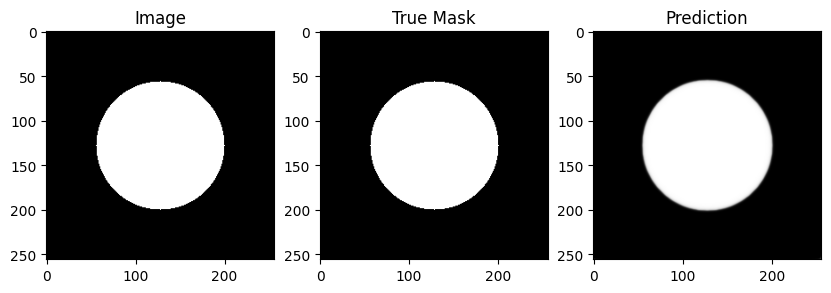

In [ ]:
# ======================================
# WORKING MEDICAL SEGMENTATION DEMO
# Creates dataset automatically
# ======================================

!pip install torch torchvision matplotlib opencv-python -q

import os, cv2, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------- CREATE DATASET --------
os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)

for i in range(20):
    img = np.zeros((256,256), dtype=np.uint8)
    cv2.circle(img, (128,128), np.random.randint(30,80), 255, -1)

    mask = img.copy()

    cv2.imwrite(f"dataset/images/img{i}.png", img)
    cv2.imwrite(f"dataset/masks/img{i}.png", mask)

print("Dataset created successfully!")

# -------- DEVICE --------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -------- DATASET CLASS --------
class MedicalDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(img_dir)

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        name = self.images[idx]
        img = cv2.imread(os.path.join(self.img_dir,name),0)/255.0
        mask = cv2.imread(os.path.join(self.mask_dir,name),0)/255.0
        img = torch.tensor(img,dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask,dtype=torch.float32).unsqueeze(0)
        return img, mask

# -------- MODEL --------
class DoubleConv(nn.Module):
    def __init__(self,i,o):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(i,o,3,padding=1), nn.ReLU(),
            nn.Conv2d(o,o,3,padding=1), nn.ReLU()
        )
    def forward(self,x): return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(1,64)
        self.d2 = DoubleConv(64,128)
        self.d3 = DoubleConv(128,256)
        self.pool = nn.MaxPool2d(2)
        self.u1 = DoubleConv(256+128,128)
        self.u2 = DoubleConv(128+64,64)
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out = nn.Conv2d(64,1,1)

    def forward(self,x):
        c1=self.d1(x); p1=self.pool(c1)
        c2=self.d2(p1); p2=self.pool(c2)
        c3=self.d3(p2)
        u1=self.up(c3); u1=torch.cat([u1,c2],1); c4=self.u1(u1)
        u2=self.up(c4); u2=torch.cat([u2,c1],1); c5=self.u2(u2)
        return torch.sigmoid(self.out(c5))

# -------- TRAIN --------
dataset = MedicalDataset("dataset/images","dataset/masks")
loader = DataLoader(dataset,batch_size=4,shuffle=True)

model = UNet().to(device)
opt = torch.optim.Adam(model.parameters(),1e-3)
loss_fn = nn.BCELoss()

print("\nTraining...\n")
for epoch in range(3):
    total=0
    for img,mask in loader:
        img,mask = img.to(device), mask.to(device)
        pred = model(img)
        loss = loss_fn(pred,mask)
        opt.zero_grad(); loss.backward(); opt.step()
        total+=loss.item()
    print("Epoch",epoch+1,"Loss",total/len(loader))

# -------- TEST --------
model.eval()
img,mask = dataset[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0][0].cpu()

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img[0],cmap="gray")
plt.subplot(1,3,2); plt.title("True Mask"); plt.imshow(mask[0],cmap="gray")
plt.subplot(1,3,3); plt.title("Prediction"); plt.imshow(pred,cmap="gray")
plt.show()
